# Enomoto Options Strategy Backtesting Framework

This notebook implements the quantitative analysis framework of financial analyst Josh Enomoto.

## Framework Overview

The goal is to identify statistically mispriced options by finding a "positive delta in price density dynamics" - the gap between:
- **Baseline**: Normal price behavior across all historical data
- **Sequence-Specific**: Price behavior after a specific 10-week pattern

## Key Concepts

1. **Morse Code Pattern (X-Y-Z)**:
   - X = Up weeks (Close > Open)
   - Y = Down weeks (Close <= Open)
   - Z = Trajectory ('D' if downward, 'U' if upward)

2. **Data Period**: Weekly data from January 1, 2019 onwards

3. **Price Points**:
   - Anchor Price: Open of the first week in the 10-week window
   - Resolution Price: Low price at a future week (e.g., 8 weeks out)

## Step 1: Import Required Libraries

In [1]:
# Core data manipulation and numerical libraries
import pandas as pd
import numpy as np
from datetime import datetime

# Data acquisition
import yfinance as yf

# Statistical analysis
from scipy import stats
from scipy.stats import gaussian_kde, binomtest
from sklearn.mixture import GaussianMixture

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully!")

All libraries imported successfully!


## Step 2: Data Acquisition Function

Download weekly historical data from January 1, 2019 to present.

In [9]:
def download_weekly_data(ticker, start_date='2019-01-01'):
    """
    Download weekly historical data for a given ticker.
    
    Parameters:
    -----------
    ticker : str
        Stock ticker symbol
    start_date : str
        Start date for historical data (default: '2019-01-01')
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with weekly OHLC data
    """
    print(f"\nDownloading weekly data for {ticker} from {start_date}...")
    
    # Download data with weekly interval
    data = yf.download(ticker, start=start_date, interval='1wk', progress=False)
    
    # --- START FIX ---
    # Handle potential MultiIndex columns returned by yfinance
    if isinstance(data.columns, pd.MultiIndex):
        # Assumes the structure is ('Open', 'KDP'), ('Close', 'KDP')
        # We drop the second level (ticker) to get clean columns
        data.columns = data.columns.droplevel(1)
    # --- END FIX ---

    # Reset index to make Date a column
    data = data.reset_index()
    
    # Ensure we have the necessary columns
    required_cols = ['Date', 'Open', 'Close', 'Low', 'High']
    for col in required_cols:
        if col not in data.columns:
            raise ValueError(f"Missing required column: {col}")
    
    print(f"Downloaded {len(data)} weeks of data")
    print(f"Date range: {data['Date'].min()} to {data['Date'].max()}")
    
    return data

## Step 3: Feature Engineering - The "Morse Code" Pattern

Implement the pattern detection logic that identifies 10-week sequences.

In [3]:
def get_sequence(window):
    """
    Calculate the 'Morse Code' pattern for a 10-week window.
    
    Pattern format: "X-Y-Z" where:
    - X = number of up weeks (Close > Open)
    - Y = number of down weeks (Close <= Open)
    - Z = trajectory ('D' for downward, 'U' for upward)
    
    Parameters:
    -----------
    window : pd.DataFrame
        10-week DataFrame window with 'Open' and 'Close' columns
    
    Returns:
    --------
    str
        Pattern string in format "X-Y-Z" (e.g., "3-7-D")
    """
    # Count up weeks (Close > Open)
    up_weeks = (window['Close'] > window['Open']).sum()
    
    # Count down weeks (Close <= Open)
    down_weeks = (window['Close'] <= window['Open']).sum()
    
    # Determine trajectory: Compare last Close to first Open
    # 'D' if closing price of 10th week < opening price of 1st week
    # Use .values to ensure we get scalar values, not Series
    trajectory = 'D' if window['Close'].values[-1] < window['Open'].values[0] else 'U'
    
    # Format as "X-Y-Z"
    sequence_key = f"{up_weeks}-{down_weeks}-{trajectory}"
    
    return sequence_key

## Step 4: Historical Pattern Analysis - Rolling Window

Create a master DataFrame that analyzes all 10-week windows and their future outcomes.

In [4]:
def build_master_dataframe(data, window_size=10, future_weeks=10):
    """
    Build master analysis DataFrame with all 10-week windows and their future outcomes.
    
    Parameters:
    -----------
    data : pd.DataFrame
        Historical weekly data
    window_size : int
        Size of the rolling window (default: 10)
    future_weeks : int
        Number of future weeks to track (default: 10)
    
    Returns:
    --------
    pd.DataFrame
        Master DataFrame with pattern analysis
    """
    print(f"\nBuilding master DataFrame with {window_size}-week rolling windows...")
    
    results = []
    
    # Iterate through all possible 10-week windows
    for i in range(len(data) - window_size - future_weeks + 1):
        # Extract the 10-week window
        window = data.iloc[i:i + window_size]
        
        # Calculate pattern sequence
        sequence_key = get_sequence(window)
        
        # Get anchor price (Open of first week)
        # Use .values to ensure we get scalar values, not Series
        anchor_price = window['Open'].values[0]
        
        # Get start and end dates
        start_date = window['Date'].values[0]
        end_date = window['Date'].values[-1]
        
        # Build result row
        row = {
            'start_date': start_date,
            'end_date': end_date,
            'anchor_price': anchor_price,
            'sequence_key': sequence_key
        }
        
        # Add future resolution prices (Low prices for next N weeks)
        for week_offset in range(1, future_weeks + 1):
            future_idx = i + window_size + week_offset - 1
            if future_idx < len(data):
                row[f'future_week_{week_offset}_low'] = data['Low'].values[future_idx]
            else:
                row[f'future_week_{week_offset}_low'] = np.nan
        
        results.append(row)
    
    master_df = pd.DataFrame(results)
    print(f"Created master DataFrame with {len(master_df)} windows")
    print(f"Found {master_df['sequence_key'].nunique()} unique patterns")
    
    return master_df

## Step 5: Distribution Analysis and Metric Calculation

Calculate key statistical metrics including clustering, delta, and p-values.

In [5]:
def calculate_clustering_price(data, bandwidth='scott'):
    """
    Calculate the clustering price (mode/peak) of a distribution using KDE.
    
    Parameters:
    -----------
    data : pd.Series or np.array
        Price data
    bandwidth : str or float
        KDE bandwidth method (default: 'scott')
    
    Returns:
    --------
    float
        The price at the peak of the KDE distribution
    """
    # Remove NaN values and ensure proper 1D numpy array format
    if isinstance(data, pd.Series):
        clean_data = data.dropna().values
    else:
        clean_data = np.array(data)
        clean_data = clean_data[~np.isnan(clean_data)]
    
    # Ensure 1D array
    clean_data = clean_data.flatten()
    
    if len(clean_data) < 2:
        return np.nan
    
    # Fit KDE
    kde = gaussian_kde(clean_data, bw_method=bandwidth)
    
    # Create evaluation grid
    x_grid = np.linspace(clean_data.min(), clean_data.max(), 1000)
    kde_values = kde(x_grid)
    
    # Find peak (mode)
    peak_idx = np.argmax(kde_values)
    clustering_price = x_grid[peak_idx]
    
    return clustering_price


def calculate_metrics(master_df, target_sequence_key, resolution_price_col, current_anchor_price):
    """
    Calculate all core Enomoto metrics.
    
    Parameters:
    -----------
    master_df : pd.DataFrame
        Master analysis DataFrame
    target_sequence_key : str
        Target pattern (e.g., '3-7-D')
    resolution_price_col : str
        Column name for resolution price (e.g., 'future_week_8_low')
    current_anchor_price : float
        Current anchor price for exceedance calculation
    
    Returns:
    --------
    dict
        Dictionary with all calculated metrics
    """
    # Extract baseline and sequence-specific data
    baseline_data = master_df[resolution_price_col].dropna()
    sequence_mask = master_df['sequence_key'] == target_sequence_key
    sequence_data = master_df.loc[sequence_mask, resolution_price_col].dropna()
    
    if len(sequence_data) == 0:
        print(f"WARNING: No data found for sequence '{target_sequence_key}'")
        return None
    
    # 1. Calculate clustering prices (mode of KDE)
    baseline_clustering = calculate_clustering_price(baseline_data)
    sequence_clustering = calculate_clustering_price(sequence_data)
    
    # 2. Positive Delta
    positive_delta = (sequence_clustering - baseline_clustering) / baseline_clustering
    
    # 3. Pattern Rarity
    pattern_rarity = len(sequence_data) / len(baseline_data)
    
    # 4. Exceedance Ratio (sequence-specific)
    exceedance_ratio = (sequence_data > current_anchor_price).mean()
    
    # 5. Terminal Median
    terminal_median = sequence_data.median()
    
    # 6. P-Value (Binomial Test)
    baseline_success_rate = (baseline_data > current_anchor_price).mean()
    sequence_success_count = (sequence_data > current_anchor_price).sum()
    n_trials = len(sequence_data)
    
    # Perform binomial test
    binom_result = binomtest(sequence_success_count, n=n_trials, p=baseline_success_rate, alternative='greater')
    p_value = binom_result.pvalue
    
    # Compile metrics
    metrics = {
        'baseline_clustering': baseline_clustering,
        'sequence_clustering': sequence_clustering,
        'positive_delta': positive_delta,
        'positive_delta_pct': positive_delta * 100,
        'pattern_rarity': pattern_rarity,
        'pattern_rarity_pct': pattern_rarity * 100,
        'exceedance_ratio': exceedance_ratio,
        'exceedance_ratio_pct': exceedance_ratio * 100,
        'terminal_median': terminal_median,
        'p_value': p_value,
        'baseline_success_rate': baseline_success_rate,
        'sequence_success_count': sequence_success_count,
        'n_trials': n_trials,
        'baseline_median': baseline_data.median(),
        'sequence_median': sequence_data.median(),
        'baseline_count': len(baseline_data),
        'sequence_count': len(sequence_data)
    }
    
    return metrics, baseline_data, sequence_data

## Step 6: Chart Generation

Create verification charts: Baseline distribution and bimodal comparison.

In [6]:
def plot_baseline_distribution(ticker, baseline_data):
    """
    Plot Chart 1: Simple baseline distribution with median line.
    
    Parameters:
    -----------
    ticker : str
        Stock ticker
    baseline_data : pd.Series
        Baseline price data
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot KDE
    sns.kdeplot(data=baseline_data, ax=ax, color='steelblue', linewidth=2, fill=True, alpha=0.3)
    
    # Add median line
    median_val = baseline_data.median()
    ax.axvline(median_val, color='red', linestyle='--', linewidth=2, label=f'Median: ${median_val:.2f}')
    
    # Labels and title
    ax.set_xlabel('Price ($)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Density', fontsize=12, fontweight='bold')
    ax.set_title(f'{ticker} - Baseline Distribution (All Outcomes)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_bimodal_distribution(ticker, target_sequence_key, baseline_data, sequence_data):
    """
    Plot Chart 2: Bimodal/juxtaposed distribution with GMM overlay.
    
    Parameters:
    -----------
    ticker : str
        Stock ticker
    target_sequence_key : str
        Target pattern
    baseline_data : pd.Series
        Baseline price data
    sequence_data : pd.Series
        Sequence-specific price data
    """
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Layer 1: Baseline Distribution KDE
    sns.kdeplot(data=baseline_data, ax=ax, color='green', linewidth=2, 
                fill=True, alpha=0.3, label='Baseline (All Outcomes)')
    
    # Layer 2: Sequence-Specific Distribution KDE
    sns.kdeplot(data=sequence_data, ax=ax, color='blue', linewidth=2.5, 
                fill=False, alpha=0.8, label=f'Sequence-Specific ({target_sequence_key})')
    
    # Layer 3: Gaussian Mixture Model (Bimodal)
    if len(sequence_data) >= 2:
        try:
            # Fit GMM with 2 components
            gmm = GaussianMixture(n_components=2, random_state=42)
            gmm.fit(sequence_data.values.reshape(-1, 1))
            
            # Generate PDF for GMM
            x_range = np.linspace(sequence_data.min(), sequence_data.max(), 1000)
            
            # Calculate GMM PDF
            logprob = gmm.score_samples(x_range.reshape(-1, 1))
            pdf = np.exp(logprob)
            
            # Plot GMM
            ax.plot(x_range, pdf, color='red', linestyle='--', linewidth=2, 
                   label='Bimodal (GMM)', alpha=0.8)
        except Exception as e:
            print(f"Warning: Could not fit GMM - {e}")
    
    # Add median lines
    baseline_median = baseline_data.median()
    sequence_median = sequence_data.median()
    
    ax.axvline(baseline_median, color='green', linestyle=':', linewidth=1.5, alpha=0.7)
    ax.axvline(sequence_median, color='blue', linestyle=':', linewidth=1.5, alpha=0.7)
    
    # Labels and title
    ax.set_xlabel('Price ($)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Density', fontsize=12, fontweight='bold')
    ax.set_title(f'{ticker} - Bimodal Distribution (Sequence: {target_sequence_key})', 
                fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Step 7: Main Analysis Function

Integrate all components into a single analysis pipeline.

In [7]:
def run_enomoto_analysis(ticker, target_resolution_week=8, 
                         start_date='2019-01-01', generate_charts=True):
    """
    Run complete Enomoto analysis for a given ticker.
    Automatically detects the current pattern from the most recent 10-week window.
    
    Parameters:
    -----------
    ticker : str
        Stock ticker symbol
    target_resolution_week : int
        Future week for resolution price (default: 8)
    start_date : str
        Start date for historical data (default: '2019-01-01')
    generate_charts : bool
        Whether to generate verification charts (default: True)
    
    Returns:
    --------
    dict
        Dictionary with all metrics and data
    """
    print("="*80)
    print(f"ENOMOTO ANALYSIS: {ticker}")
    print("="*80)
    
    # Step 1: Download data
    data = download_weekly_data(ticker, start_date)
    
    # Step 2: Get current 10-week window and calculate target sequence
    print("\nCalculating current pattern from most recent 10 weeks...")
    if len(data) < 10:
        print("ERROR: Not enough data. Need at least 10 weeks.")
        return None
    
    current_window = data.iloc[-10:]
    target_sequence_key = get_sequence(current_window)
    
    print(f"Detected Pattern: {target_sequence_key}")
    print(f"Resolution Week: {target_resolution_week}")
    print("="*80)
    
    # Step 3: Build master DataFrame
    master_df = build_master_dataframe(data)
    
    # Step 4: Define resolution column
    resolution_price_col = f'future_week_{target_resolution_week}_low'
    
    # Step 5: Get current anchor price (most recent 10-week window)
    # Use .item() to ensure we get a scalar value
    current_anchor_price = float(master_df['anchor_price'].iloc[-1])
    print(f"\nCurrent anchor price: ${current_anchor_price:.2f}")
    
    # Step 6: Calculate metrics
    print("\nCalculating metrics...")
    result = calculate_metrics(master_df, target_sequence_key, resolution_price_col, current_anchor_price)
    
    if result is None:
        print("Analysis failed - no data for target sequence")
        return None
    
    metrics, baseline_data, sequence_data = result
    
    # Step 7: Print metrics
    print("\n" + "="*80)
    print("RESULTS")
    print("="*80)
    print(f"\n1. PRICE CLUSTERING:")
    print(f"   Baseline Clustering:          ${metrics['baseline_clustering']:.2f}")
    print(f"   Sequence Clustering:          ${metrics['sequence_clustering']:.2f}")
    print(f"\n2. POSITIVE DELTA:              {metrics['positive_delta_pct']:.2f}%")
    print(f"\n3. PATTERN RARITY:              {metrics['pattern_rarity_pct']:.2f}% ({metrics['sequence_count']}/{metrics['baseline_count']} windows)")
    print(f"\n4. EXCEEDANCE RATIO:            {metrics['exceedance_ratio_pct']:.2f}%")
    print(f"   (Probability resolution > anchor)")
    print(f"\n5. TERMINAL MEDIAN:             ${metrics['terminal_median']:.2f}")
    print(f"\n6. STATISTICAL SIGNIFICANCE:")
    print(f"   P-Value:                      {metrics['p_value']:.6f}")
    print(f"   Baseline Success Rate:        {metrics['baseline_success_rate']*100:.2f}%")
    print(f"   Sequence Success Rate:        {metrics['exceedance_ratio']*100:.2f}%")
    
    if metrics['p_value'] < 0.05:
        print(f"   ✓ Statistically significant (p < 0.05)")
    else:
        print(f"   ✗ Not statistically significant (p >= 0.05)")
    
    print(f"\n7. ADDITIONAL METRICS:")
    print(f"   Baseline Median:              ${metrics['baseline_median']:.2f}")
    print(f"   Sequence Median:              ${metrics['sequence_median']:.2f}")
    print("="*80)
    
    # Step 8: Generate charts
    if generate_charts:
        print("\nGenerating verification charts...\n")
        plot_baseline_distribution(ticker, baseline_data)
        plot_bimodal_distribution(ticker, target_sequence_key, baseline_data, sequence_data)
    
    # Return all data
    return {
        'ticker': ticker,
        'target_sequence_key': target_sequence_key,  # Include the detected sequence
        'metrics': metrics,
        'master_df': master_df,
        'baseline_data': baseline_data,
        'sequence_data': sequence_data,
        'current_anchor_price': current_anchor_price
    }

## Step 8: Verification Runs

Test the framework against known analyses to verify accuracy.

### Verification 1: KDP (Keurig Dr Pepper)

The pattern will be automatically detected from the most recent 10 weeks.

**Historical Expected Results (as of original analysis):**
- Baseline clustering: ~$27.22
- Sequence clustering: ~$29
- Pattern: 3-7-D

ENOMOTO ANALYSIS: KDP

Downloaded 357 weeks of data
Date range: 2019-01-01 00:00:00 to 2025-10-28 00:00:00

Calculating current pattern from most recent 10 weeks...
Detected Pattern: 3-7-D
Resolution Week: 8

Building master DataFrame with 10-week rolling windows...
Created master DataFrame with 338 windows
Found 15 unique patterns

Current anchor price: $32.50

Calculating metrics...

RESULTS

1. PRICE CLUSTERING:
   Baseline Clustering:          $31.67
   Sequence Clustering:          $31.22

2. POSITIVE DELTA:              -1.42%

3. PATTERN RARITY:              5.03% (17/338 windows)

4. EXCEEDANCE RATIO:            11.76%
   (Probability resolution > anchor)

5. TERMINAL MEDIAN:             $30.08

6. STATISTICAL SIGNIFICANCE:
   P-Value:                      0.936422
   Baseline Success Rate:        23.67%
   Sequence Success Rate:        11.76%
   ✗ Not statistically significant (p >= 0.05)

7. ADDITIONAL METRICS:
   Baseline Median:              $30.51
   Sequence Median:      

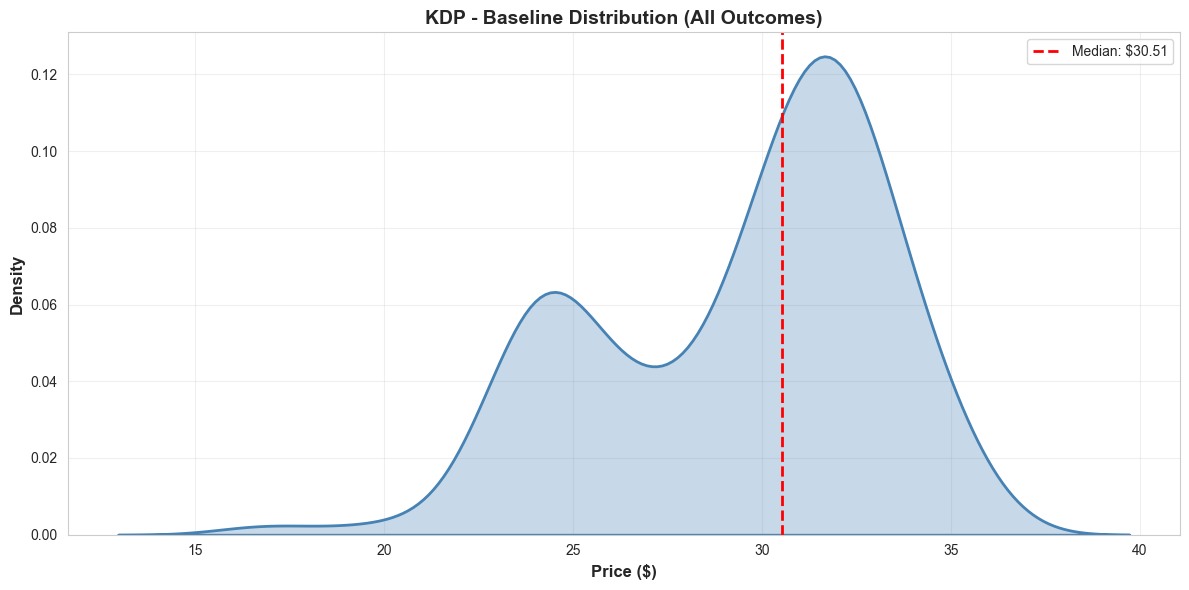

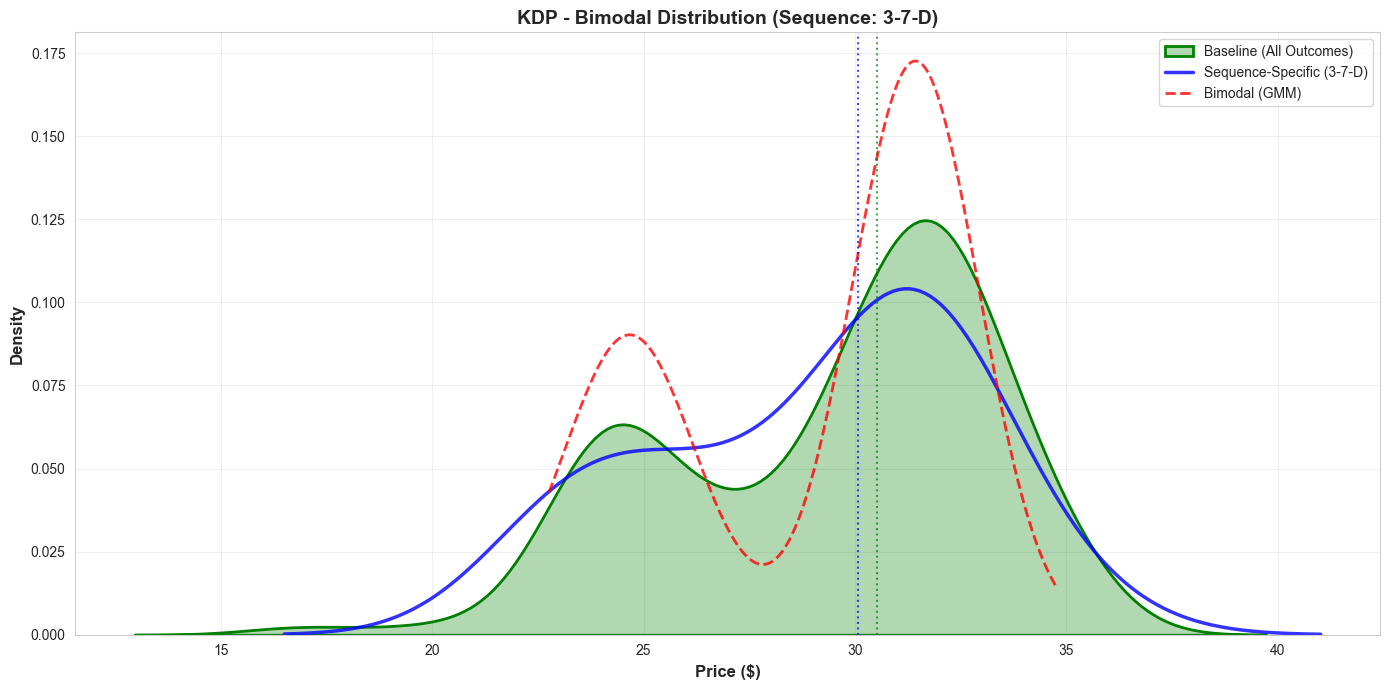

In [10]:
# Run analysis for KDP
# Pattern will be auto-detected from the most recent 10 weeks
kdp_results = run_enomoto_analysis(
    ticker='KDP',
    target_resolution_week=8,
    generate_charts=True
)

### Verification 2: TXN (Texas Instruments)

The pattern will be automatically detected from the most recent 10 weeks.

**Historical Expected Results (as of original analysis):**
- Sequence-specific clustering: ~$167
- Recent anchor price: ~$161.46
- Pattern: 3-7-D

ENOMOTO ANALYSIS: TXN

Downloaded 357 weeks of data
Date range: 2019-01-01 00:00:00 to 2025-10-28 00:00:00

Calculating current pattern from most recent 10 weeks...
Detected Pattern: 3-7-D
Resolution Week: 8

Building master DataFrame with 10-week rolling windows...
Created master DataFrame with 338 windows
Found 12 unique patterns

Current anchor price: $194.84

Calculating metrics...

RESULTS

1. PRICE CLUSTERING:
   Baseline Clustering:          $155.02
   Sequence Clustering:          $161.67

2. POSITIVE DELTA:              4.29%

3. PATTERN RARITY:              7.99% (27/338 windows)

4. EXCEEDANCE RATIO:            3.70%
   (Probability resolution > anchor)

5. TERMINAL MEDIAN:             $157.28

6. STATISTICAL SIGNIFICANCE:
   P-Value:                      0.431664
   Baseline Success Rate:        2.07%
   Sequence Success Rate:        3.70%
   ✗ Not statistically significant (p >= 0.05)

7. ADDITIONAL METRICS:
   Baseline Median:              $152.42
   Sequence Median:     

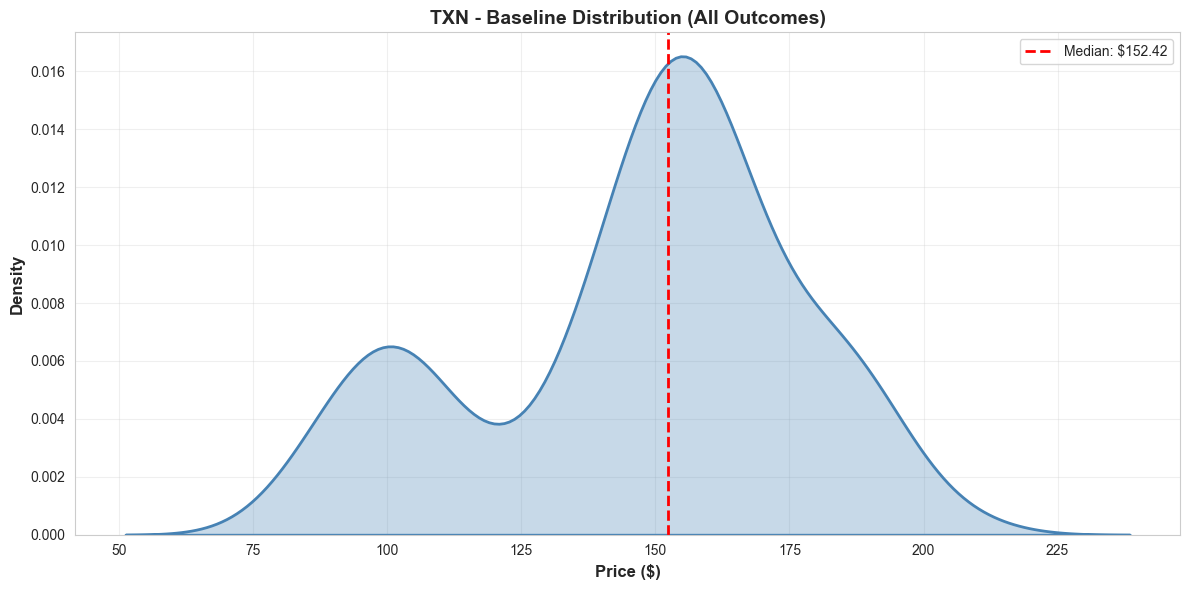

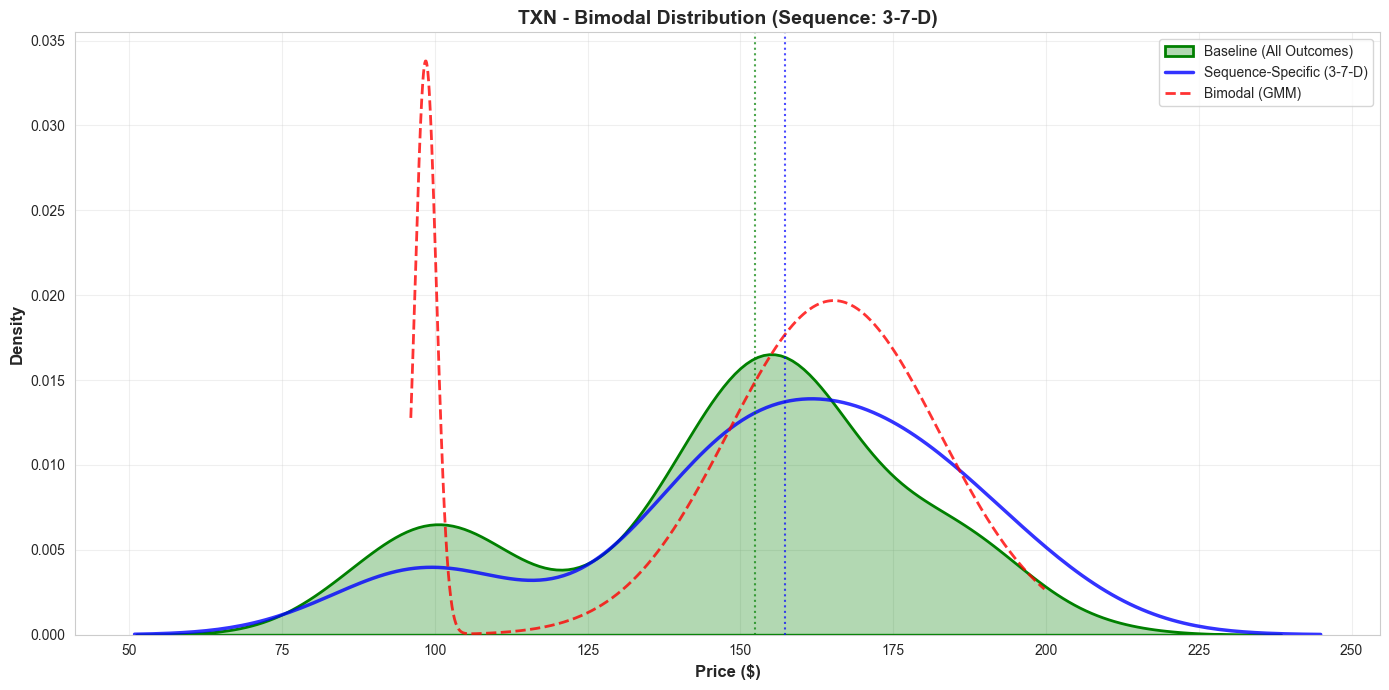

In [11]:
# Run analysis for TXN
# Pattern will be auto-detected from the most recent 10 weeks
txn_results = run_enomoto_analysis(
    ticker='TXN',
    target_resolution_week=8,
    generate_charts=True
)

### Verification 3: CVNA (Carvana)

The pattern will be automatically detected from the most recent 10 weeks.

**Historical Expected Results (as of original analysis):**
- Baseline clustering: ~$319
- Sequence clustering: ~$363
- Pattern: 6-4-D

ENOMOTO ANALYSIS: CVNA

Downloaded 357 weeks of data
Date range: 2019-01-01 00:00:00 to 2025-10-28 00:00:00

Calculating current pattern from most recent 10 weeks...
Detected Pattern: 6-4-D
Resolution Week: 8

Building master DataFrame with 10-week rolling windows...
Created master DataFrame with 338 windows
Found 14 unique patterns

Current anchor price: $288.50

Calculating metrics...

RESULTS

1. PRICE CLUSTERING:
   Baseline Clustering:          $47.09
   Sequence Clustering:          $64.88

2. POSITIVE DELTA:              37.78%

3. PATTERN RARITY:              4.73% (16/338 windows)

4. EXCEEDANCE RATIO:            18.75%
   (Probability resolution > anchor)

5. TERMINAL MEDIAN:             $147.10

6. STATISTICAL SIGNIFICANCE:
   P-Value:                      0.213282
   Baseline Success Rate:        10.06%
   Sequence Success Rate:        18.75%
   ✗ Not statistically significant (p >= 0.05)

7. ADDITIONAL METRICS:
   Baseline Median:              $98.81
   Sequence Median:   

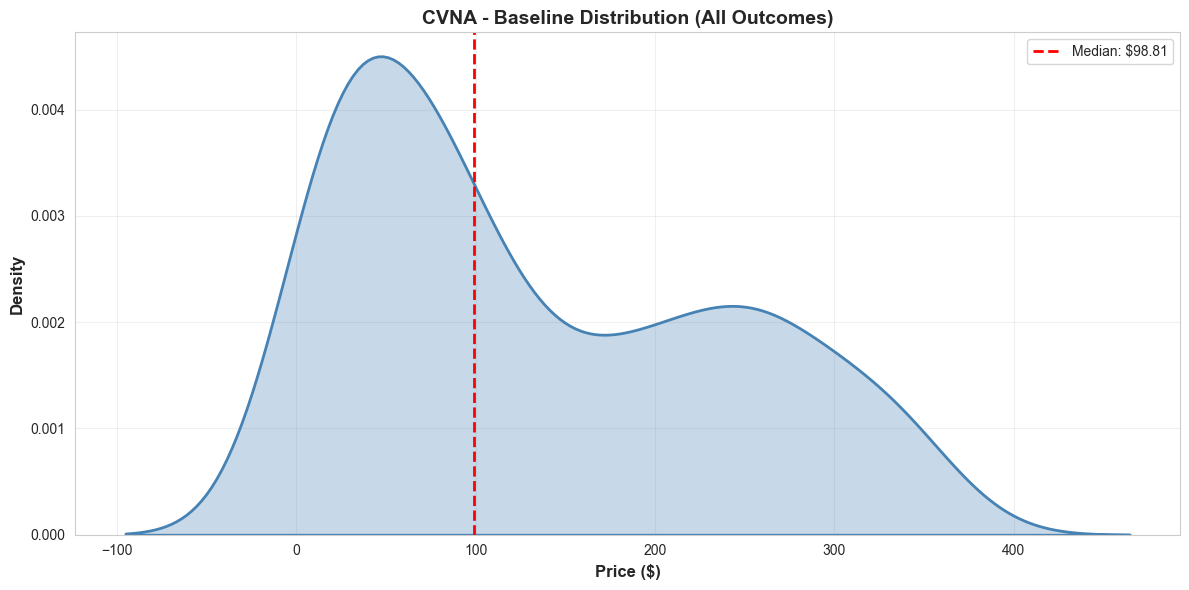

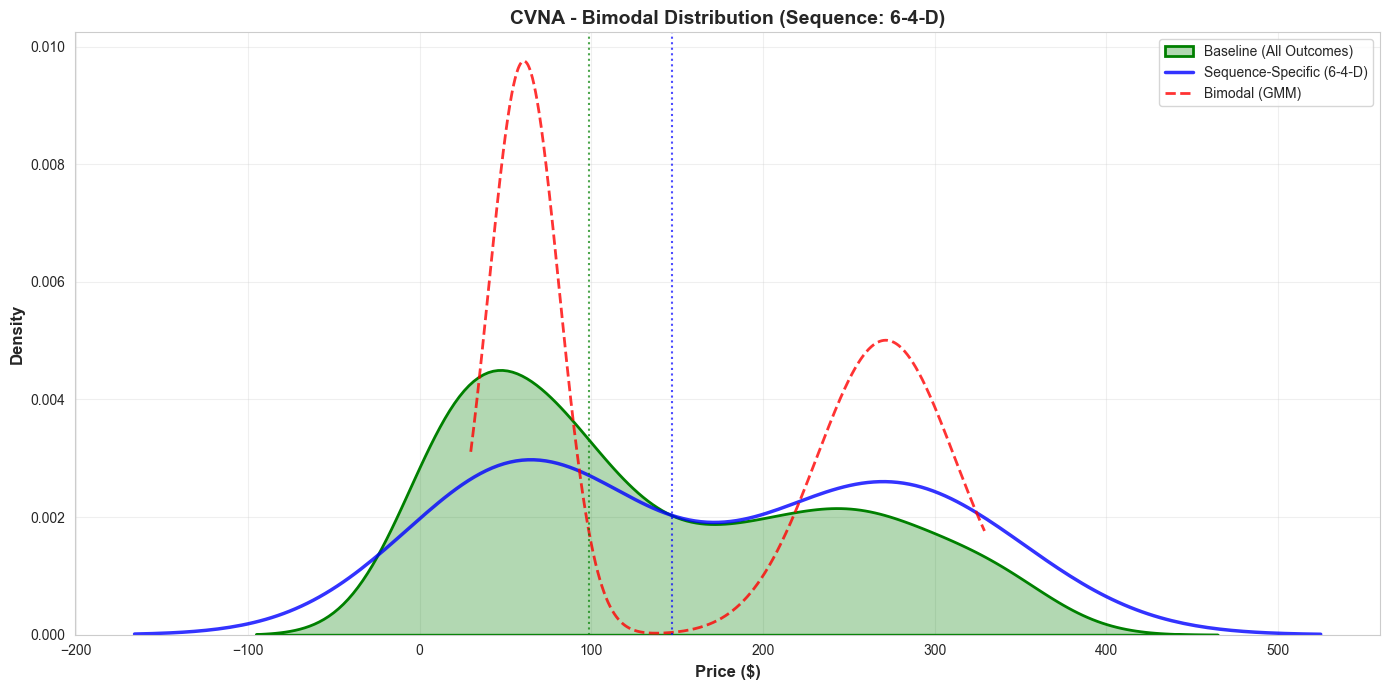

In [12]:
# Run analysis for CVNA
# Pattern will be auto-detected from the most recent 10 weeks
cvna_results = run_enomoto_analysis(
    ticker='CVNA',
    target_resolution_week=8,
    generate_charts=True
)

## Step 9: Summary Comparison

Compare results across all three verification runs.

In [13]:
# Create summary comparison table
if kdp_results and txn_results and cvna_results:
    summary_data = []
    
    for result in [kdp_results, txn_results, cvna_results]:
        if result:
            m = result['metrics']
            summary_data.append({
                'Ticker': result['ticker'],
                'Baseline Clustering': f"${m['baseline_clustering']:.2f}",
                'Sequence Clustering': f"${m['sequence_clustering']:.2f}",
                'Positive Delta': f"{m['positive_delta_pct']:.2f}%",
                'Pattern Rarity': f"{m['pattern_rarity_pct']:.2f}%",
                'Exceedance Ratio': f"{m['exceedance_ratio_pct']:.2f}%",
                'P-Value': f"{m['p_value']:.6f}",
                'Significant': 'Yes' if m['p_value'] < 0.05 else 'No'
            })
    
    summary_df = pd.DataFrame(summary_data)
    
    print("\n" + "="*120)
    print("VERIFICATION SUMMARY")
    print("="*120)
    print(summary_df.to_string(index=False))
    print("="*120)


VERIFICATION SUMMARY
Ticker Baseline Clustering Sequence Clustering Positive Delta Pattern Rarity Exceedance Ratio  P-Value Significant
   KDP              $31.67              $31.22         -1.42%          5.03%           11.76% 0.936422          No
   TXN             $155.02             $161.67          4.29%          7.99%            3.70% 0.431664          No
  CVNA              $47.09              $64.88         37.78%          4.73%           18.75% 0.213282          No


## Step 10: Custom Analysis

Use this cell to run your own custom analyses.

In [ ]:
# Example: Analyze a custom ticker
# Pattern will be automatically detected from the most recent 10 weeks
# Uncomment and modify as needed

# custom_results = run_enomoto_analysis(
#     ticker='AAPL',
#     target_resolution_week=8,
#     generate_charts=True
# )

## Conclusion

This notebook implements the complete Enomoto quantitative analysis framework for identifying statistically mispriced options opportunities.

### Key Takeaways:

1. **Pattern Recognition**: The "Morse Code" system identifies specific 10-week price patterns
2. **Automatic Detection**: The current pattern is automatically calculated from the most recent 10 weeks
3. **Statistical Analysis**: Compares baseline vs. sequence-specific distributions
4. **Positive Delta**: Measures the gap in price clustering between distributions
5. **Significance Testing**: Binomial tests validate statistical significance
6. **Visualization**: KDE and GMM charts provide visual verification

### Usage:

To analyze any ticker:
```python
results = run_enomoto_analysis(
    ticker='YOUR_TICKER',
    target_resolution_week=8
)
```

The analysis will automatically:
- Download historical weekly data
- Identify the current 10-week pattern
- Find historical matches to that pattern
- Calculate statistical metrics and probabilities

### Important Notes:

- All analysis uses weekly data from January 1, 2019 onwards
- The current pattern is auto-detected from the most recent 10 weeks
- Resolution prices use the `Low` for conservative bull call spread planning
- P-values < 0.05 indicate statistically significant patterns
- Higher exceedance ratios suggest better options opportunities